# This file compares and analyses the IMBI_Marko miner

In [1]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, 'C:/Users/Marko/Desktop/GIt/IMBI_Master')

In [2]:
from local_pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.objects.log.importer.xes import importer as xes_importer
from local_pm4py.algo.analysis import custom_enum
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py import view_petri_net
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py import precision_alignments
from pm4py import precision_token_based_replay
from pm4py import discover_petri_net_heuristics
from pm4py.convert import convert_to_petri_net
from pm4py.algo.discovery.inductive import algorithm as pm4py_algorithm
from pm4py.algo.discovery.inductive.variants import imf as pm4py_imf
import pandas as pd
from pm4py.algo.discovery.inductive.algorithm import Variants as ind_Variants
from local_pm4py.algo.analysis import Optimzation_Goals
import matplotlib.pyplot as plt
import numpy as np
import math
import fpdf
from PIL import Image
import os

In [3]:
def f1_score(a, b):
  # try: catch
  if math.isclose(a+b,0):
    return 0
  return 2 * (a * b) / (a + b)

In [4]:
def visualize_cuts(fileName):
  pdf = fpdf.FPDF(format='letter') #pdf format
  pdf.add_page() #create new page
  pdf.set_font("Arial", size=8) # font and textsize

  i = 0
  try:
    while(True):
      with open("imbi_cuts/cut" + str(i) + ".txt") as f:
        pdf.cell(150, 4, txt="Cut: " + str(i + 1), ln=1, align="C")
        pdf.cell(1000, 4, txt="cut | type | cost_p | cost_m | cost_ratio", ln=1, align="L")
        pdf.cell(1000, 4, txt="", ln=1, align="L")
        lines = f.readlines()
        readLines = 0
        for line in lines:
          if readLines == 0:
            outputLine = line.replace(" ", " | ")
          else:
            outputLine = line
          pdf.cell(1000, 4, txt=outputLine, ln=1, align="L")
          readLines += 1
          if readLines == 3:
            readLines = 0
            pdf.cell(1000, 4, txt="", ln=1, align="L")
        img = Image.open("imbi_cuts/cut" + str(i) + ".png")
        width,height = img.size
        # print(width, height)
        pdf.image("imbi_cuts/cut" + str(i) + ".png",w=min(150,width/3),h=min(150,height/3))
        pdf.add_page()
      i += 1
  except:
    pdf.output(fileName + ".pdf")

In [5]:
def visualize_petriNet(df, miner, logPName, logMName = ""):
  df_temp = df[df["miner"] == miner]
  df_temp = df_temp[df_temp["logM_Name"] == logMName]
  df_temp = df_temp[df_temp["logP_Name"] == logPName]
  for net, im, fm in zip(df_temp.net, df_temp.im, df_temp.fm):
    print("Displaying: " + str(miner) + " " + str(logPName) + " " + str(logMName))
    view_petri_net(net, im, fm)

In [6]:
def visualize_All_petriNet(df, miner):
  df_temp = df[df["miner"] == miner]
  for logPName, logMName in zip(df_temp.logP_Name, df_temp.logM_Name):
    visualize_petriNet(df,miner,logPName,logMName)

In [7]:
def runDoubleLogEvaluation(df,log,logM, name,net, im, fm, logPName = "",logMName = "", imf_noiseThreshold = 0, hm_dependency_threshold = 0,im_bi_sup = 0, im_bi_ratio = 0):
  mes = Optimzation_Goals.apply_petri(log,logM,net,im,fm)

  df = pd.concat([df, pd.DataFrame.from_records([{
    "miner" : name,
    "logP_Name": logPName[:logPName.rfind(".")],
    "logM_Name": logMName[:logMName.rfind(".")],
    "imf_noise_thr" : imf_noiseThreshold,
    "hm_depen_thr" : hm_dependency_threshold,
    "im_bi_sup" : im_bi_sup,
    "im_bi_ratio" : im_bi_ratio,
    "acc_logs": mes['acc'],
    "fitP" : mes['fitP'],
    "fitM" : mes['fitM'],
    "f1_fit_logs": mes['F1'],
    "precP" : mes['precision'],
    "net": net,
    "im" : im,
    "fm" : fm
  }])])
  return df

In [8]:
def runSingleLogEvaluation(df,log,logM, name,net, im, fm, logPName = "",logMName = "", imf_noiseThreshold = 0, hm_dependency_threshold = 0,im_bi_sup = 0, im_bi_ratio = 0):
  parameters = {pn_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT:"pdf"}
  gviz = pn_visualizer.apply(net, im, fm, parameters=parameters)

  try:
    fitness_token = replay_fitness_evaluator.apply(log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)["log_fitness"]
  except:
    fitness_token = 0
  try:
    fitness_align = replay_fitness_evaluator.apply(log, net, im, fm, variant=replay_fitness_evaluator.Variants.ALIGNMENT_BASED)["log_fitness"]
  except:
    fitness_align = 0
    
  try:
    prec_token = precision_token_based_replay(log, net, im, fm)
  except:
    prec_token = 0
    
  try:
    prec_alignment = precision_alignments(log, net, im, fm)
  except:
    prec_alignment = 0

  df = pd.concat([df, pd.DataFrame.from_records([{
      "miner" : name,
      "logP_Name": logPName,
      "logM_Name": logMName,
      "imf_noise_thr" : imf_noiseThreshold,
      "hm_depen_thr" : hm_dependency_threshold,
      "im_bi_sup" : im_bi_sup,
      "im_bi_ratio" : im_bi_ratio,
      "fit_tok": fitness_token,
      "fit_alig": fitness_align,
      "prec_tok": prec_token,
      "prec_alig": prec_alignment,
      "f1_tok": f1_score(fitness_token, prec_token),
      "f1_alig": f1_score(fitness_align, prec_alignment),
      "net": net,
      "im" : im,
      "fm" : fm
  }])])
  return df

In [9]:
def add_Model_To_Database(df,log,logM, name,net, im, fm, logPName = "",logMName = "", imf_noiseThreshold = 0, hm_dependency_threshold = 0,im_bi_sup = 0, im_bi_ratio = 0):
  if logMName == "":
    df = runSingleLogEvaluation(df,log,logM, name,net, im, fm, logPName,logMName, imf_noiseThreshold, hm_dependency_threshold,im_bi_sup, im_bi_ratio)
  else:
    df = runDoubleLogEvaluation(df,log,logM, name,net, im, fm, logPName,logMName, imf_noiseThreshold, hm_dependency_threshold,im_bi_sup, im_bi_ratio)
  return df

In [10]:
def getF1Value(df, miner, logPName, logMName, support, ratio):
  dftemp = df[df["miner"] == miner]
  dftemp = dftemp[dftemp["logP_Name"] == logPName[:logPName.rfind(".")]]
  dftemp = dftemp[dftemp["logM_Name"] == logMName[:logPName.rfind(".")]]
  dftemp = dftemp[dftemp["im_bi_sup"] == support]
  dftemp = dftemp[dftemp["im_bi_ratio"] == ratio]
  if len(dftemp.index) > 1:
    raise Exception("Error, too many rows.")
  return dftemp["f1_fit_logs"].iloc[0]

# a = getF1Value(df, "IMbi_ali", "lp_2012.", "lm_2012.",0.4,0.3)
# b = getF1Value(df, "IMbi_mar", "lp_2012.", "lm_2012.",0.4,0.3)
# if int(a) > int(b):
#   display("test")


In [11]:
def applyMinerToLog(df, logPathP, logPathM,logPName, logMName = "", noiseThreshold = 0.0, dependency_threshold=0.0, support = 0, ratio = 0):
  logP = xes_importer.apply(logPathP)
  if logMName == "":
    logM = logP
    # inductive miner
    print("Running IM")
    pt = pm4py_algorithm.apply(logP,variant=ind_Variants.IM)
    net, im, fm = convert_to_petri_net(pt)
    df = add_Model_To_Database(df=df, log=logP, logM=logM,net=net,im=im,fm=fm,name="IM",logPName=logPName)
    
    #imf 
    print("Running IMF")
    parameters = {pm4py_imf.IMFParameters.NOISE_THRESHOLD : noiseThreshold}
    pt = pm4py_algorithm.apply(logP,variant=ind_Variants.IMf, parameters=parameters)
    net, im, fm = convert_to_petri_net(pt)
    df = add_Model_To_Database(df=df, log=logP, logM=logM,net=net,im=im,fm=fm,name="IMF",logPName=logPName,imf_noiseThreshold=noiseThreshold)
    
    #hm
    print("Running HM")
    net, im, fm = discover_petri_net_heuristics(logP,dependency_threshold=dependency_threshold)
    df = add_Model_To_Database(df=df, log=logP, logM=logM,net=net,im=im,fm=fm,name="HM",logPName=logPName,hm_dependency_threshold=dependency_threshold)
  else:
    logM = xes_importer.apply(logPathM)
    
  # imbi_ali
  print("Running IMbi_ali")
  cost_Variant = custom_enum.Cost_Variant.ACTIVITY_FREQUENCY_SCORE
  net, im, fm = inductive_miner.apply_bi(logP,logM, variant=inductive_miner.Variants.IMbi, sup=support, ratio=ratio, size_par=len(logP)/len(logM), cost_Variant=cost_Variant)
  df = add_Model_To_Database(df=df,log=logP, logM=logM,net=net,im=im,fm=fm,name="IMbi_ali",logPName=logPName, logMName=logMName,im_bi_sup=support,im_bi_ratio=ratio)
  
  fileName_cuts_ali = "cuts_IMbi_ali_sup_" + str(support) + "_ratio_" + str(ratio) + "_logP_" + logPName[:logPName.rfind(".")] + "_logM_" + logMName[:logMName.rfind(".")]
  visualize_cuts(fileName_cuts_ali)
  
  for f in os.listdir("imbi_cuts"):
    os.remove(os.path.join("imbi_cuts", f))
  
  #imbi_mar
  print("Running IMbi_mar")
  cost_Variant = custom_enum.Cost_Variant.ACTIVITY_RELATION_SCORE
  net, im, fm = inductive_miner.apply_bi(logP,logM, variant=inductive_miner.Variants.IMbi, sup=support, ratio=ratio, size_par=len(logP)/len(logM), cost_Variant=cost_Variant)
  df = add_Model_To_Database(df=df, log=logP, logM=logM,net=net,im=im,fm=fm,name="IMbi_mar",logPName=logPName, logMName=logMName, im_bi_sup=support,im_bi_ratio=ratio)
  
  fileName_cuts_mar = "cuts_IMbi_mar_sup_" + str(support) + "_ratio_" + str(ratio) + "_logP-" + logPName[:logPName.rfind(".")] + "_logM-" + logMName[:logMName.rfind(".")]
  visualize_cuts(fileName_cuts_mar)
  
  for f in os.listdir("imbi_cuts"):
    os.remove(os.path.join("imbi_cuts", f))
  
  # for double log
  marImproved = False
  if logMName != "":
    f1_ali = getF1Value(df,"IMbi_ali",logPName,logMName,support,ratio)
    f1_mar = getF1Value(df,"IMbi_mar",logPName,logMName,support,ratio)
    if f1_ali < f1_mar:
      display("Mar > Ali")
      marImproved = True
      if os.path.exists(fileName_cuts_ali+ ".pdf"):
        os.remove(fileName_cuts_ali+ ".pdf")
      if os.path.exists(fileName_cuts_mar+ ".pdf"):
        os.remove(fileName_cuts_mar + ".pdf")
    else:
      display("Ali > Mar")
  return df, marImproved

In [12]:
columns = ["miner", "logP_Name", "logM_Name","imf_noise_thr","hm_depen_thr","im_bi_sup","im_bi_ratio", "fit_tok", "fit_alig", "prec_tok", "prec_alig", "f1_tok", "f1_alig", "net", "im", "fm"]
df = pd.DataFrame(data=None, index=None, columns=columns, dtype=None, copy=None)

In [13]:
rootPath = "C:/Users/Marko/Desktop/IMbi_Data/analysing/"

# lpNames = ["lp_2012.xes", "lp_2017.xes", "lp_2018.xes"]
lpNames = ["lp_2012.xes"]

# lMNames = ["lm_2012.xes", "lm_2017.xes", "lm_2018.xes"]
lMNames = ["lm_2012.xes"]
lpPaths = []
lmPaths = []

for lp in lpNames:
  lpPaths.append((lp,rootPath + lp))
for lm in lMNames:
  lmPaths.append((lm,rootPath + lm))
  

In [14]:
for i in range(0,len(lpPaths)):
  for ratio in [0.3]:
    for sup in [0.4]:
      df, marImproved = applyMinerToLog(df, lpPaths[i][1], lmPaths[i][1], lpPaths[i][0],lmPaths[i][0], 0.2, 0.99, sup, ratio)

c:\Users\Marko\AppData\Local\Programs\Python\Python38\lib\site-packages\pm4py\util\dt_parsing\parser.py:76: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(
c:\Users\Marko\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 587/587 [00:00<00:00, 2849.42it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 310.56it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1036.14it/s]
aligning log, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 219.73it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 208.34it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 977.24it/s]
aligning log, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 135.55it/s]


'Ali > Mar'

In [14]:
totalRuns = len(lpPaths) * 4 * 3
cur = 1
runs = 0
improving_runs = 0

for i in range(0,len(lpPaths)):
  for ratio in [0, 0.3, 0.6, 1]:
    for sup in [1, 0.8, 0.4]:
      display("Running: " + lpPaths[i][0] + " " + str(cur) + "/" + str(totalRuns))
      display("i: " + str(i) + " ratio: " + str(ratio) + " sup: " + str(sup))
      display("Stats: " + str(improving_runs) + "/" + str(runs))
      df, marImproved = applyMinerToLog(df, lpPaths[i][1], lmPaths[i][1], lpPaths[i][0],lmPaths[i][0], 0.2, 0.99, sup, ratio)
      if marImproved:
        improving_runs += 1
      runs += 1
      cur += 1
  
# display(df)

Running: lp_2012.xes 1/36
i: 0 ratio: 0 sup: 1


c:\Users\Marko\AppData\Local\Programs\Python\Python38\lib\site-packages\pm4py\util\dt_parsing\parser.py:76: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(
c:\Users\Marko\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 587/587 [00:00<00:00, 2835.76it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 354.61it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 767.84it/s]
aligning log, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 280.80it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 215.52it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1036.14it/s]
aligning log, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 160.92it/s]


'Mar > Ali'

Running: lp_2012.xes 2/36
i: 0 ratio: 0 sup: 0.8


parsing log, completed traces :: 100%|██████████| 587/587 [00:00<00:00, 2736.61it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 370.38it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1011.84it/s]
aligning log, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 265.58it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 352.11it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1023.83it/s]
aligning log, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 287.39it/s]


'Mar > Ali'

Running: lp_2012.xes 3/36
i: 0 ratio: 0 sup: 0.4


parsing log, completed traces :: 100%|██████████| 587/587 [00:00<00:00, 2680.38it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 188.68it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 710.76it/s]
aligning log, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 166.95it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 280.90it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 467.40it/s]
aligning log, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 212.12it/s]


'Mar > Ali'

Running: lp_2012.xes 4/36
i: 0 ratio: 0.3 sup: 1


parsing log, completed traces :: 100%|██████████| 587/587 [00:00<00:00, 2063.27it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 282.48it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 417.48it/s]
aligning log, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 331.08it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 423.76it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1194.44it/s]
aligning log, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 316.13it/s]


'Mar > Ali'

Running: lp_2012.xes 5/36
i: 0 ratio: 0.3 sup: 0.8


parsing log, completed traces :: 100%|██████████| 587/587 [00:00<00:00, 2870.43it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 387.60it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1194.48it/s]
aligning log, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 333.33it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 431.04it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1178.06it/s]
aligning log, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 345.07it/s]


'Mar > Ali'

Running: lp_2012.xes 6/36
i: 0 ratio: 0.3 sup: 0.4


parsing log, completed traces :: 100%|██████████| 587/587 [00:00<00:00, 2870.44it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 257.73it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 859.98it/s]
aligning log, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 220.22it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 221.25it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 945.08it/s]
aligning log, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 142.03it/s]


'Ali > Mar'

Running: lp_2012.xes 7/36
i: 0 ratio: 0.6 sup: 1


parsing log, completed traces :: 100%|██████████| 587/587 [00:00<00:00, 2801.92it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 416.67it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1178.09it/s]
aligning log, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 343.86it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 458.72it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1194.39it/s]
aligning log, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 326.66it/s]


'Mar > Ali'

Running: lp_2012.xes 8/36
i: 0 ratio: 0.6 sup: 0.8


parsing log, completed traces :: 100%|██████████| 587/587 [00:00<00:00, 2898.73it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 403.21it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1228.62it/s]
aligning log, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 340.28it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 381.70it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1194.47it/s]
aligning log, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 339.10it/s]


'Mar > Ali'

Running: lp_2012.xes 9/36
i: 0 ratio: 0.6 sup: 0.4


parsing log, completed traces :: 100%|██████████| 587/587 [00:00<00:00, 2227.70it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 282.49it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 977.21it/s]
aligning log, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 167.24it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 212.73it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 834.99it/s]
aligning log, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 139.21it/s]


'Ali > Mar'

Running: lp_2012.xes 10/36
i: 0 ratio: 1 sup: 1


parsing log, completed traces :: 100%|██████████| 587/587 [00:00<00:00, 2822.13it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 384.61it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1264.68it/s]
aligning log, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 334.47it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 409.85it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1048.79it/s]
aligning log, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 316.13it/s]


'Mar > Ali'

Running: lp_2012.xes 11/36
i: 0 ratio: 1 sup: 0.8


parsing log, completed traces :: 100%|██████████| 587/587 [00:00<00:00, 2749.42it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 384.62it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1162.17it/s]
aligning log, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 343.86it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 420.17it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1194.41it/s]
aligning log, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 317.15it/s]


'Mar > Ali'

Running: lp_2012.xes 12/36
i: 0 ratio: 1 sup: 0.4


parsing log, completed traces :: 100%|██████████| 587/587 [00:00<00:00, 2223.49it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 270.27it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 977.30it/s]
aligning log, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 198.38it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 222.22it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 934.78it/s]
aligning log, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 133.15it/s]


'Ali > Mar'

Running: lp_2017.xes 13/36
i: 1 ratio: 0 sup: 1


parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 2035.28it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 446/446 [00:02<00:00, 221.23it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 798.27it/s]
aligning log, completed variants :: 100%|██████████| 82/82 [00:00<00:00, 261.15it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 446/446 [00:02<00:00, 159.22it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 796.41it/s]
aligning log, completed variants :: 100%|██████████| 82/82 [00:00<00:00, 154.72it/s]


'Ali > Mar'

Running: lp_2017.xes 14/36
i: 1 ratio: 0 sup: 0.8


parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 1895.74it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 446/446 [00:02<00:00, 212.63it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 781.62it/s]
aligning log, completed variants :: 100%|██████████| 82/82 [00:00<00:00, 267.10it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 446/446 [00:02<00:00, 190.97it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 812.61it/s]
aligning log, completed variants :: 100%|██████████| 82/82 [00:00<00:00, 269.29it/s]


'Ali > Mar'

Running: lp_2017.xes 15/36
i: 1 ratio: 0 sup: 0.4


parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 1842.75it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 446/446 [00:05<00:00, 80.59it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 772.80it/s]
aligning log, completed variants :: 100%|██████████| 82/82 [00:00<00:00, 105.20it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 446/446 [00:02<00:00, 165.83it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 744.26it/s]
aligning log, completed variants :: 100%|██████████| 82/82 [00:00<00:00, 266.67it/s]


'Ali > Mar'

Running: lp_2017.xes 16/36
i: 1 ratio: 0.3 sup: 1


parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 1824.26it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 446/446 [00:02<00:00, 209.88it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 837.00it/s]
aligning log, completed variants :: 100%|██████████| 82/82 [00:00<00:00, 258.68it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 446/446 [00:02<00:00, 166.60it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 719.04it/s]
aligning log, completed variants :: 100%|██████████| 82/82 [00:00<00:00, 216.36it/s]


'Ali > Mar'

Running: lp_2017.xes 17/36
i: 1 ratio: 0.3 sup: 0.8


parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 1895.13it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 446/446 [00:01<00:00, 223.67it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 840.22it/s]
aligning log, completed variants :: 100%|██████████| 82/82 [00:00<00:00, 275.17it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 446/446 [00:02<00:00, 200.67it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 877.42it/s]
aligning log, completed variants :: 100%|██████████| 82/82 [00:00<00:00, 286.71it/s]


'Ali > Mar'

Running: lp_2017.xes 18/36
i: 1 ratio: 0.3 sup: 0.4


parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 1905.97it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 446/446 [00:05<00:00, 83.58it/s] 
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 835.54it/s]
aligning log, completed variants :: 100%|██████████| 82/82 [00:00<00:00, 113.34it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 446/446 [00:02<00:00, 174.25it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 722.51it/s]
aligning log, completed variants :: 100%|██████████| 82/82 [00:00<00:00, 271.98it/s]


'Ali > Mar'

Running: lp_2017.xes 19/36
i: 1 ratio: 0.6 sup: 1


parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 1862.20it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 446/446 [00:02<00:00, 218.95it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 796.94it/s]
aligning log, completed variants :: 100%|██████████| 82/82 [00:00<00:00, 276.56it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 446/446 [00:02<00:00, 166.79it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 839.93it/s]
aligning log, completed variants :: 100%|██████████| 82/82 [00:00<00:00, 225.58it/s]


'Ali > Mar'

Running: lp_2017.xes 20/36
i: 1 ratio: 0.6 sup: 0.8


parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 2024.98it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 446/446 [00:01<00:00, 223.73it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 782.13it/s]
aligning log, completed variants :: 100%|██████████| 82/82 [00:00<00:00, 279.86it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 446/446 [00:02<00:00, 202.87it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 829.76it/s]
aligning log, completed variants :: 100%|██████████| 82/82 [00:00<00:00, 284.23it/s]


'Ali > Mar'

Running: lp_2017.xes 21/36
i: 1 ratio: 0.6 sup: 0.4


parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 1913.27it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 446/446 [00:05<00:00, 85.64it/s] 
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 819.55it/s]
aligning log, completed variants :: 100%|██████████| 82/82 [00:00<00:00, 113.26it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 446/446 [00:02<00:00, 174.42it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 769.33it/s]
aligning log, completed variants :: 100%|██████████| 82/82 [00:00<00:00, 206.55it/s]


'Ali > Mar'

Running: lp_2017.xes 22/36
i: 1 ratio: 1 sup: 1


parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 1893.34it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 446/446 [00:02<00:00, 222.22it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 791.94it/s]
aligning log, completed variants :: 100%|██████████| 82/82 [00:00<00:00, 266.23it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 446/446 [00:02<00:00, 166.89it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 834.09it/s]
aligning log, completed variants :: 100%|██████████| 82/82 [00:00<00:00, 227.46it/s]


'Ali > Mar'

Running: lp_2017.xes 23/36
i: 1 ratio: 1 sup: 0.8


parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 1928.02it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 446/446 [00:01<00:00, 225.14it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 839.93it/s]
aligning log, completed variants :: 100%|██████████| 82/82 [00:00<00:00, 277.03it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 446/446 [00:02<00:00, 202.73it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 892.78it/s]
aligning log, completed variants :: 100%|██████████| 82/82 [00:00<00:00, 267.54it/s]


'Ali > Mar'

Running: lp_2017.xes 24/36
i: 1 ratio: 1 sup: 0.4


parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 1876.76it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 446/446 [00:05<00:00, 86.44it/s] 
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 782.89it/s]
aligning log, completed variants :: 100%|██████████| 82/82 [00:00<00:00, 113.65it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 446/446 [00:02<00:00, 172.33it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 794.57it/s]
aligning log, completed variants :: 100%|██████████| 82/82 [00:00<00:00, 286.71it/s]


'Ali > Mar'

Running: lp_2018.xes 25/36
i: 2 ratio: 0 sup: 1


parsing log, completed traces :: 100%|██████████| 3000/3000 [00:00<00:00, 3409.09it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 197/197 [00:01<00:00, 147.18it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 737.08it/s]
aligning log, completed variants :: 100%|██████████| 137/137 [00:00<00:00, 181.10it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 197/197 [00:02<00:00, 78.78it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 638.11it/s]
aligning log, completed variants :: 100%|██████████| 137/137 [00:01<00:00, 79.79it/s]


'Ali > Mar'

Running: lp_2018.xes 26/36
i: 2 ratio: 0 sup: 0.8


parsing log, completed traces :: 100%|██████████| 3000/3000 [00:00<00:00, 3225.80it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 197/197 [00:01<00:00, 149.36it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 846.47it/s]
aligning log, completed variants :: 100%|██████████| 137/137 [00:00<00:00, 180.51it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 197/197 [00:02<00:00, 80.05it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 589.07it/s]
aligning log, completed variants :: 100%|██████████| 137/137 [00:01<00:00, 78.52it/s]


'Ali > Mar'

Running: lp_2018.xes 27/36
i: 2 ratio: 0 sup: 0.4


parsing log, completed traces :: 100%|██████████| 3000/3000 [00:00<00:00, 3498.54it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 197/197 [00:01<00:00, 121.64it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 709.47it/s]
aligning log, completed variants :: 100%|██████████| 137/137 [00:00<00:00, 143.83it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 197/197 [00:01<00:00, 148.62it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 776.12it/s]
aligning log, completed variants :: 100%|██████████| 137/137 [00:00<00:00, 197.83it/s]


'Mar > Ali'

Running: lp_2018.xes 28/36
i: 2 ratio: 0.3 sup: 1


parsing log, completed traces :: 100%|██████████| 3000/3000 [00:00<00:00, 3454.23it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 197/197 [00:01<00:00, 148.46it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 832.65it/s]
aligning log, completed variants :: 100%|██████████| 137/137 [00:00<00:00, 150.30it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 197/197 [00:02<00:00, 73.88it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 521.53it/s]
aligning log, completed variants :: 100%|██████████| 137/137 [00:01<00:00, 72.28it/s]


'Ali > Mar'

Running: lp_2018.xes 29/36
i: 2 ratio: 0.3 sup: 0.8


parsing log, completed traces :: 100%|██████████| 3000/3000 [00:00<00:00, 3218.89it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 197/197 [00:01<00:00, 139.32it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 810.76it/s]
aligning log, completed variants :: 100%|██████████| 137/137 [00:00<00:00, 171.79it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 197/197 [00:02<00:00, 73.25it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 615.60it/s]
aligning log, completed variants :: 100%|██████████| 137/137 [00:01<00:00, 74.07it/s]


'Ali > Mar'

Running: lp_2018.xes 30/36
i: 2 ratio: 0.3 sup: 0.4


parsing log, completed traces :: 100%|██████████| 3000/3000 [00:00<00:00, 3264.42it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 197/197 [00:01<00:00, 106.37it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 590.65it/s]
aligning log, completed variants :: 100%|██████████| 137/137 [00:01<00:00, 133.85it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 197/197 [00:01<00:00, 116.29it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 709.28it/s]
aligning log, completed variants :: 100%|██████████| 137/137 [00:00<00:00, 191.07it/s]


'Mar > Ali'

Running: lp_2018.xes 31/36
i: 2 ratio: 0.6 sup: 1


parsing log, completed traces :: 100%|██████████| 3000/3000 [00:00<00:00, 3167.90it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 197/197 [00:01<00:00, 139.72it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 818.27it/s]
aligning log, completed variants :: 100%|██████████| 137/137 [00:00<00:00, 177.12it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 197/197 [00:02<00:00, 72.40it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 623.56it/s]
aligning log, completed variants :: 100%|██████████| 137/137 [00:01<00:00, 73.70it/s]


'Ali > Mar'

Running: lp_2018.xes 32/36
i: 2 ratio: 0.6 sup: 0.8


parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 2916.87it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 197/197 [00:01<00:00, 139.96it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 765.42it/s]
aligning log, completed variants :: 100%|██████████| 137/137 [00:00<00:00, 175.30it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 197/197 [00:02<00:00, 73.80it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 514.85it/s]
aligning log, completed variants :: 100%|██████████| 137/137 [00:01<00:00, 74.82it/s]


'Ali > Mar'

Running: lp_2018.xes 33/36
i: 2 ratio: 0.6 sup: 0.4


parsing log, completed traces :: 100%|██████████| 3000/3000 [00:00<00:00, 3556.61it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 197/197 [00:01<00:00, 116.53it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 757.28it/s]
aligning log, completed variants :: 100%|██████████| 137/137 [00:00<00:00, 139.87it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 197/197 [00:01<00:00, 148.85it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 834.23it/s]
aligning log, completed variants :: 100%|██████████| 137/137 [00:00<00:00, 187.16it/s]


'Mar > Ali'

Running: lp_2018.xes 34/36
i: 2 ratio: 1 sup: 1


parsing log, completed traces :: 100%|██████████| 3000/3000 [00:00<00:00, 3291.28it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 197/197 [00:01<00:00, 118.96it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 708.14it/s]
aligning log, completed variants :: 100%|██████████| 137/137 [00:00<00:00, 141.31it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 197/197 [00:02<00:00, 66.13it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 810.27it/s]
aligning log, completed variants :: 100%|██████████| 137/137 [00:01<00:00, 74.95it/s]


'Mar > Ali'

Running: lp_2018.xes 35/36
i: 2 ratio: 1 sup: 0.8


parsing log, completed traces :: 100%|██████████| 3000/3000 [00:00<00:00, 3573.55it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 197/197 [00:01<00:00, 118.21it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 774.53it/s]
aligning log, completed variants :: 100%|██████████| 137/137 [00:00<00:00, 141.46it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 197/197 [00:02<00:00, 66.73it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 791.17it/s]
aligning log, completed variants :: 100%|██████████| 137/137 [00:01<00:00, 75.46it/s]


'Mar > Ali'

Running: lp_2018.xes 36/36
i: 2 ratio: 1 sup: 0.4


parsing log, completed traces :: 100%|██████████| 3000/3000 [00:00<00:00, 3201.77it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 197/197 [00:01<00:00, 118.78it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 770.48it/s]
aligning log, completed variants :: 100%|██████████| 137/137 [00:00<00:00, 140.44it/s]


Running IMbi_mar


aligning log, completed variants :: 100%|██████████| 197/197 [00:02<00:00, 78.10it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 762.73it/s]
aligning log, completed variants :: 100%|██████████| 137/137 [00:01<00:00, 83.95it/s]


'Ali > Mar'

In [15]:

def setupYTickList(minValue, step):
  res = []
  cur = 1
  while cur > minValue:
    res.append(cur)
    cur -= step
  res.append(cur)
  return res
    

def displayDoubleLog(df, saveFig = False):
  df_grouped = df.groupby(by=["logP_Name",	"logM_Name", "im_bi_sup", "im_bi_ratio"], group_keys=True).apply(lambda x : x)
  
  numberOfPlotPerRow = 4
  rows = math.ceil(float(len(df_grouped.index.unique()))/numberOfPlotPerRow)
  cols = min(len(df_grouped.index.unique()),numberOfPlotPerRow)

  fig, axs = plt.subplots(rows, cols, figsize=(15 * (cols / numberOfPlotPerRow), 4 * rows), squeeze=False)
  fig.tight_layout(pad=10.0)
  cur_Row = 0
  cur_Col = 0
  for logGroup in df_grouped.index.unique():
    df_log_grouped = df_grouped.loc[logGroup]
    axs[cur_Row,cur_Col].set_title("LogP: " + logGroup[0] + " LogM: " + logGroup[1] + "\n" + "Sup: " + str(df_log_grouped.im_bi_sup[0]) + " ratio: " + str(df_log_grouped.im_bi_ratio[0]))
    axs[cur_Row,cur_Col].set_xlabel("Miners")
    j = 0
    xTickLabel = []
    idx = []
    minValue = 0
    for miner, acc, fitP, fitM, f1_fit in zip(df_log_grouped.miner, df_log_grouped.acc_logs, df_log_grouped.fitP, df_log_grouped.fitM, df_log_grouped.f1_fit_logs):
      minValue = min([minValue, acc, fitP, fitM, f1_fit])
      axs[cur_Row,cur_Col].bar(j,acc, color="r", label="acc")
      axs[cur_Row,cur_Col].bar(j+1,fitP, color="g", label="fitP")
      axs[cur_Row,cur_Col].bar(j+2,fitM, color="b", label="fitM")
      axs[cur_Row,cur_Col].bar(j+3,f1_fit, color="orange", label="f1_fit")
      xTickLabel.append(miner)
      idx.append(j + 1.5)
      j += 5
      
    
    axs[cur_Row,cur_Col].set_yticks(setupYTickList(minValue, 0.25))
    axs[cur_Row,cur_Col].set_xticks(idx)
    axs[cur_Row,cur_Col].set_xticklabels(xTickLabel)
    axs[cur_Row,cur_Col].legend(loc='center left', ncols=1, labels=["acc", "fitP", "fitM", "f1_fit"], bbox_to_anchor=(1, 0.5))
    cur_Col += 1
    
    if cur_Col == numberOfPlotPerRow:
      cur_Row += 1
      cur_Col = 0
      
  plt.show()

  if saveFig:
    fig.savefig("plot_" +  + ".pdf")

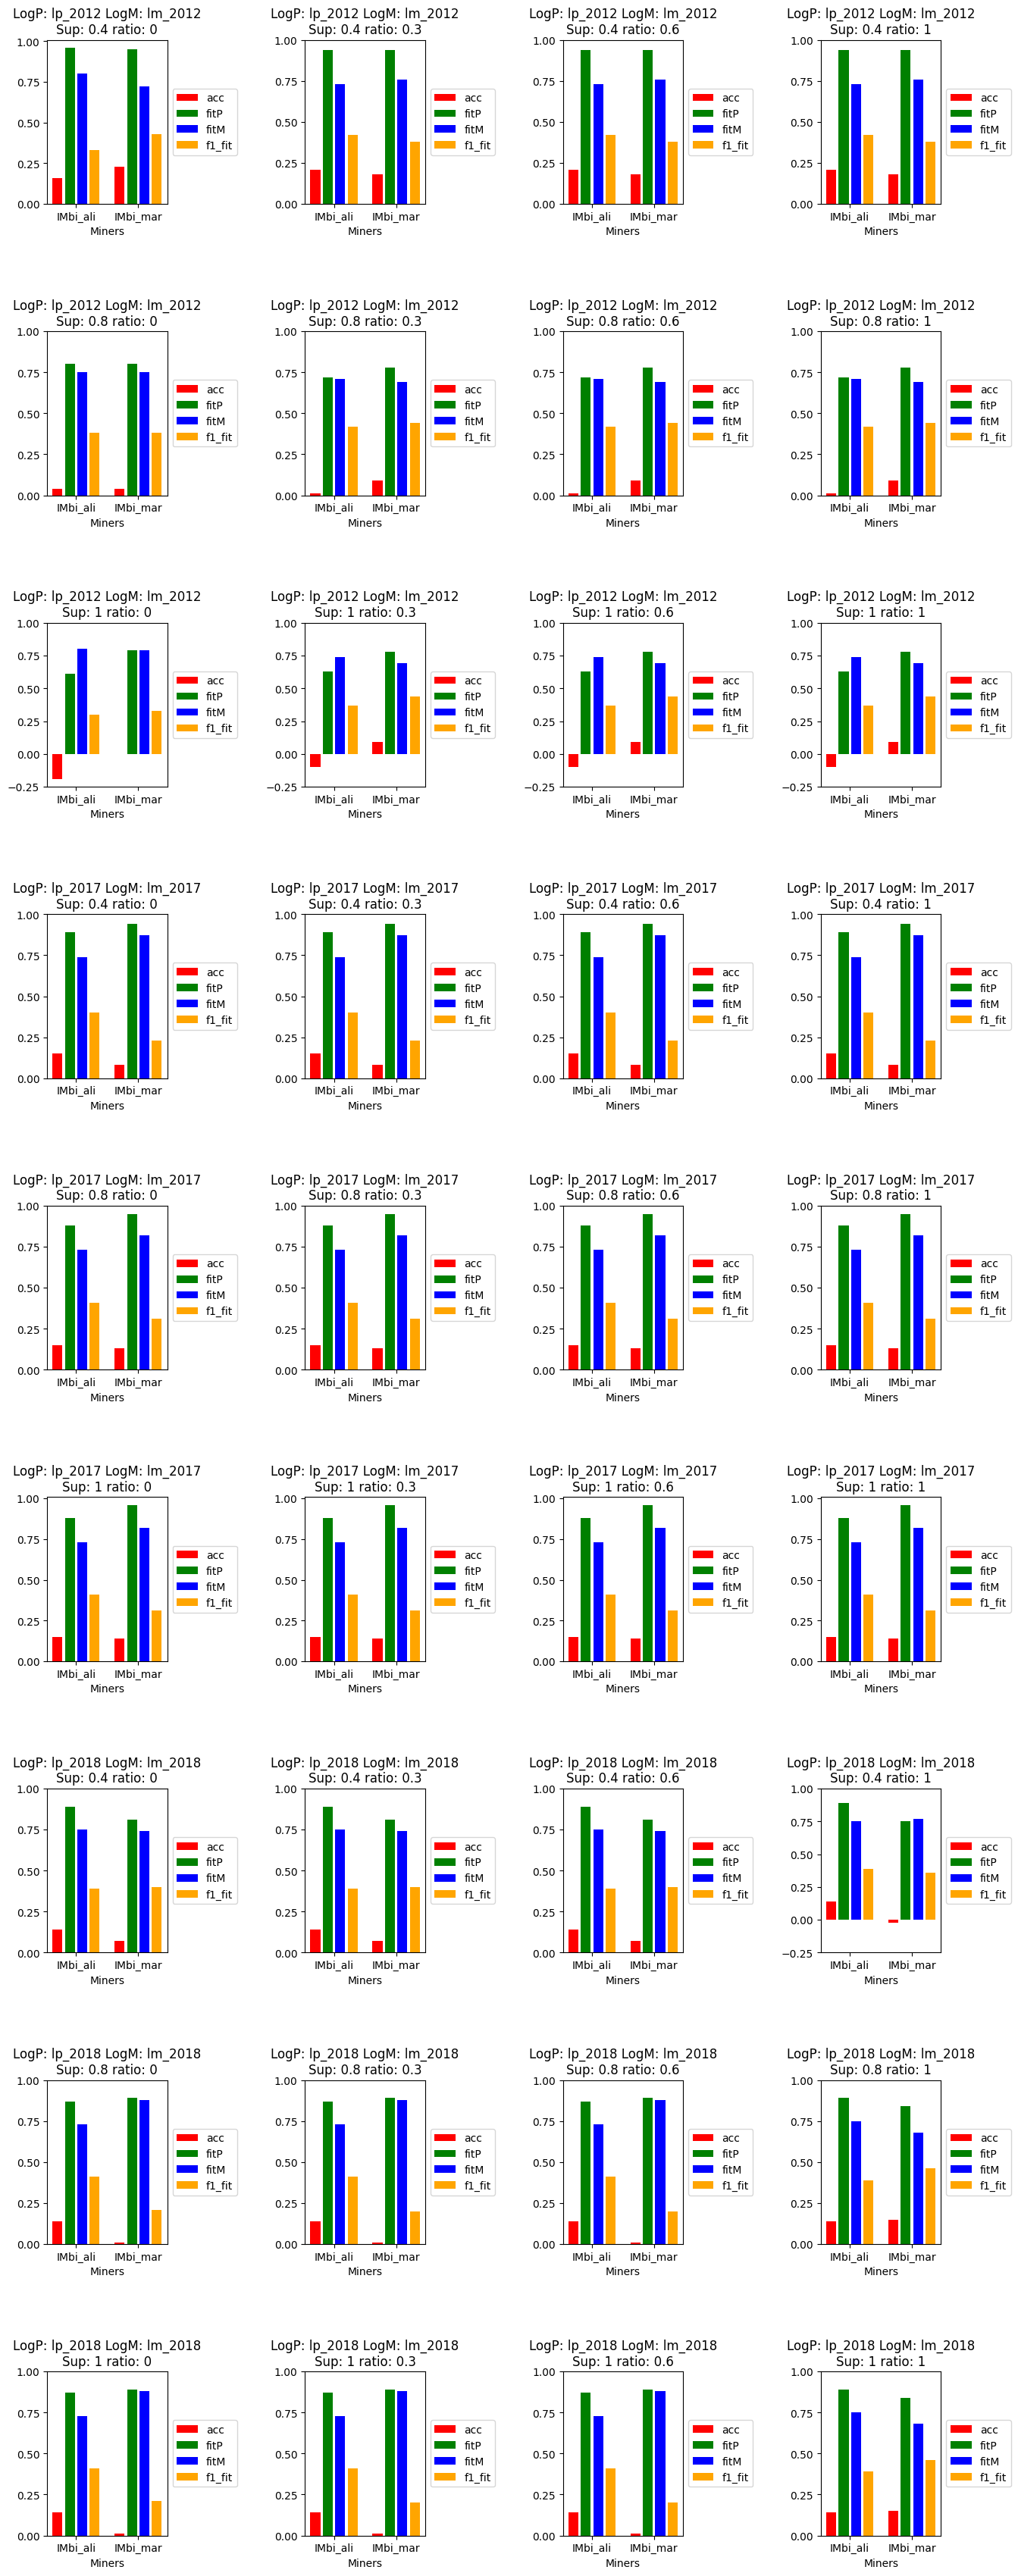

In [16]:
displayDoubleLog(df)

In [17]:

def displaySingleLog(df, saveFig = False):
  df_grouped = df.groupby(by=["logP_Name",	"logM_Name"], group_keys=True).apply(lambda x : x)

  numberOfPlotPerRow = 3
  rows = math.ceil(float(len(df_grouped.index.unique()))/numberOfPlotPerRow)
  cols = min(len(df_grouped.index.unique()),numberOfPlotPerRow)


  for f1_measure in ["f1_tok", "f1_alig"]:
    fig, axs = plt.subplots(rows, cols, figsize=(15 * (cols / numberOfPlotPerRow), 4 * rows), squeeze=False)
    fig.tight_layout(pad=10.0)
    cur_Row = 0
    cur_Col = 0
    for logGroup in df_grouped.index.unique():
      df_log_grouped = df_grouped.loc[logGroup]
      axs[cur_Row,cur_Col].set_title("LogP: " + logGroup[0] + " LogM: " + logGroup[1])
      axs[cur_Row,cur_Col].set_ylabel(f1_measure)
      axs[cur_Row,cur_Col].set_xlabel("Miners")
      j = 0
      xTickLabel = []
      idx = []
      for miner, f1_tok in zip(df_log_grouped.miner, df_log_grouped[f1_measure]):
        axs[cur_Row,cur_Col].bar(j,f1_tok, label=str(miner))
        xTickLabel.append(miner)
        idx.append(j)
        j += 1
      axs[cur_Row,cur_Col].set_xticks(idx)
      axs[cur_Row,cur_Col].set_xticklabels(xTickLabel, rotation=90)
      cur_Col += 1
      if cur_Col == numberOfPlotPerRow:
        cur_Row += 1
        cur_Col = 0
        
    plt.show()
    if saveFig:
      fig.savefig("plot_" + f1_measure + ".pdf")

In [18]:
visualize_petriNet(df, "IM", "lp_2012.xes", "lm_2012.xes")
visualize_petriNet(df, "IMbi_mar", "lp_2012.xes", "lm_2012.xes")
visualize_petriNet(df, "IMbi_ali", "lp_2012.xes", "lm_2012.xes")

In [19]:
display(df)

,miner,logP_Name,logM_Name,imf_noise_thr,hm_depen_thr,im_bi_sup,im_bi_ratio,fit_tok,fit_alig,prec_tok,...,f1_tok,f1_alig,net,im,fm,acc_logs,fitP,fitM,f1_fit_logs,precP
0,IMbi_ali,lp_2012,lm_2012,0,0,1,0,NaN,NaN,NaN,...,NaN,NaN,"places: [ p_10, p_12, p_13, p_14, p_15, p_16, ...",{source: 1},{sink: 1},-0.19,0.61,0.80,0.30,0.87
0,IMbi_mar,lp_2012,lm_2012,0,0,1,0,NaN,NaN,NaN,...,NaN,NaN,"places: [ p_10, p_11, p_3, p_4, p_5, p_6, p_7,...",{source: 1},{sink: 1},0.00,0.79,0.79,0.33,0.94
0,IMbi_ali,lp_2012,lm_2012,0,0,0.8,0,NaN,NaN,NaN,...,NaN,NaN,"places: [ p_10, p_12, p_13, p_14, p_15, p_16, ...",{source: 1},{sink: 1},0.04,0.80,0.75,0.38,0.87
0,IMbi_mar,lp_2012,lm_2012,0,0,0.8,0,NaN,NaN,NaN,...,NaN,NaN,"places: [ p_10, p_11, p_12, p_13, p_3, p_4, p_...",{source: 1},{sink: 1},0.04,0.80,0.75,0.38,1.00
0,IMbi_ali,lp_2012,lm_2012,0,0,0.4,0,NaN,NaN,NaN,...,NaN,NaN,"places: [ p_10, p_11, p_12, p_13, p_15, p_16, ...",{source: 1},{sink: 1},0.16,0.96,0.80,0.33,0.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,IMbi_mar,lp_2018,lm_2018,0,0,1,1,NaN,NaN,NaN,...,NaN,NaN,"places: [ p_10, p_13, p_14, p_15, p_3, p_4, p_...",{source: 1},{sink: 1},0.15,0.84,0.68,0.46,0.90
0,IMbi_ali,lp_2018,lm_2018,0,0,0.8,1,NaN,NaN,NaN,...,NaN,NaN,"places: [ p_10, p_11, p_12, p_13, p_17, p_18, ...",{source: 1},{sink: 1},0.14,0.89,0.75,0.39,0.85
0,IMbi_mar,lp_2018,lm_2018,0,0,0.8,1,NaN,NaN,NaN,...,NaN,NaN,"places: [ p_10, p_13, p_14, p_15, p_3, p_4, p_...",{source: 1},{sink: 1},0.15,0.84,0.68,0.46,0.90
0,IMbi_ali,lp_2018,lm_2018,0,0,0.4,1,NaN,NaN,NaN,...,NaN,NaN,"places: [ p_10, p_11, p_12, p_13, p_17, p_18, ...",{source: 1},{sink: 1},0.14,0.89,0.75,0.39,0.85


from pm4py.objects.petri_net.exporter import exporter as pnml_exporter

net, im, fm = df.iloc[4].net, df.iloc[4].im, df.iloc[4].fm
view_petri_net(net, im, fm)
pnml_exporter.apply(net, im, "petri_IMbi.pnml", final_marking=fm)